# Prevendo Notas do ENEM

O objetivo dessa análise é desenvolver um modelo que seja capaz de prever a nota no ENEM de um participante, baseado em dados socioeconômicos sobre ele.
<br><br>
O objetivo é que, a partir dessas previsões, a gente consiga analisar quais variáveis possuem maior impacto na previsão, o que pode ajudar a avaliar a necessidade do sistema de cotas.
<br><br>
Iremos julgar como injustiça um parâmetro que supostamente não deveria ser relevante para decidir a nota do participante, mas que o modelo julgou como relevante.

## Baixando dados

Os dados originais do ENEM 2022 já foram tratados para o modelo nos arquivos de tratamento.
<br><br>
Agora, os datasets de microdados e hábitos de estudo serão juntados, usando o código de inscrição dos participantes.

In [21]:
# Bibliotecas importantes
import pandas as pd
import numpy as np
import seaborn as sns

In [22]:
df_microdados = pd.read_csv("microdados_tratado.csv")
df_estudo = pd.read_csv("habitos_estudo_tratado.csv")

In [23]:
# Tamanho dos datasets originais
print(f"Tamanho Microdados: {len(df_microdados)}")
print(f"Tamanho Hábitos Estudo: {len(df_estudo)}")

Tamanho Microdados: 669781
Tamanho Hábitos Estudo: 78241


In [24]:
# Juntando datasets
df = pd.merge(df_microdados, df_estudo, on="NU_INSCRICAO")
df

,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESCOLA,TP_ENSINO,Q006,COR_RACA_1.0,COR_RACA_2.0,COR_RACA_3.0,COR_RACA_4.0,...,PANDEMIA_GESTAO,PANDEMIA_PRATICAS,GESTAO,PRATICAS,Q025,Q026,Q028,Q030,Q032,Q033
0,210056012033,3,0,1.0,0.0,5,True,False,False,False,...,2.25,1.583333,1.0,1.0,2,2,4,2,2,2
1,210057478691,3,0,1.0,0.0,1,False,False,True,False,...,1.50,1.500000,0.0,0.5,2,2,6,2,2,2
2,210056688095,4,1,1.0,0.0,2,False,True,False,False,...,1.00,1.000000,1.0,1.0,2,1,1,1,1,1
3,210057511905,3,0,1.0,0.0,1,False,False,True,False,...,1.25,1.583333,2.0,2.0,1,1,1,1,1,1
4,210057838909,3,0,1.0,0.0,2,False,False,True,False,...,1.00,1.166667,1.0,1.0,2,2,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21818,210057405995,3,1,0.0,0.0,5,False,False,True,False,...,1.75,2.166667,1.5,3.0,2,1,1,2,2,2
21819,210055900340,2,1,0.0,0.0,9,False,False,True,False,...,1.75,1.250000,1.0,1.5,2,2,2,2,2,2
21820,210054991409,3,1,1.0,0.0,4,True,False,False,False,...,1.00,1.000000,0.0,0.0,2,2,2,1,2,2
21821,210055081282,6,1,1.0,0.0,2,False,False,True,False,...,0.00,0.000000,0.0,0.0,2,2,2,2,1,1


In [25]:
# Quantas linhas sobrariam se removessemos NAs?
df.dropna().shape[0]

21823

In [26]:
# Quanto é esse valor, em porcentagem, em relaçao ao dataset original do ENEM 2022?
# Se for ver nos outros arquivos, o número total de candidatos é 3.476.105
TAMANHO_TOTAL = 3476105
tamanho_novo  = df.dropna().shape[0]
100 * tamanho_novo / TAMANHO_TOTAL

0.6278003685159108

In [27]:
# Retirando o NU_INSCRICAO, pois foi usado somente para juntar os datasets
df.drop("NU_INSCRICAO", axis=1, inplace=True)

Juntando os datasets, temos apenas 0,63% dos dados originais do ENEM 2022. Isso significa que a amostra que estamos lidando é de 0,63% da população total (onde a população são os participantes do ENEM 2022). Embora seja um valor relativamente baixo, ainda é possível fazer boas análises, contanto que essa amostra seja representativa. 

## Train/Test Split

<Axes: xlabel='NOTA_FINAL', ylabel='Count'>

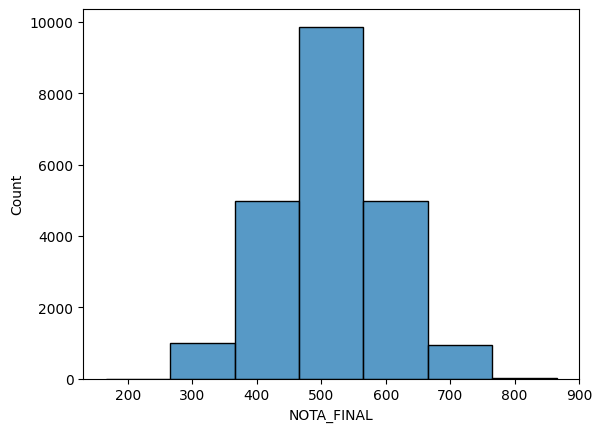

In [28]:
# Proporção das notas
import seaborn as sns
sns.histplot(x=df["NOTA_FINAL"], binwidth=100)

In [29]:
# Para garantir que os datasets de treino e teste sigam essa proporção, é interessante criar um parâmetro auxiliar
# O parâmetro irá controlar em qual faixa a nota se encontra (0-100, 100-200, ...)
from math import floor
faixa = 100
auxiliar = np.floor(df["NOTA_FINAL"] / faixa).astype(int)
auxiliar

0        7
1        4
2        5
3        3
4        4
        ..
21818    6
21819    5
21820    4
21821    3
21822    5
Name: NOTA_FINAL, Length: 21823, dtype: int64

In [30]:
# Fazendo split de treino/teste
from sklearn.model_selection import train_test_split
X = df.drop("NOTA_FINAL", axis=1)
Y = df["NOTA_FINAL"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=auxiliar)

<Axes: xlabel='NOTA_FINAL', ylabel='Count'>

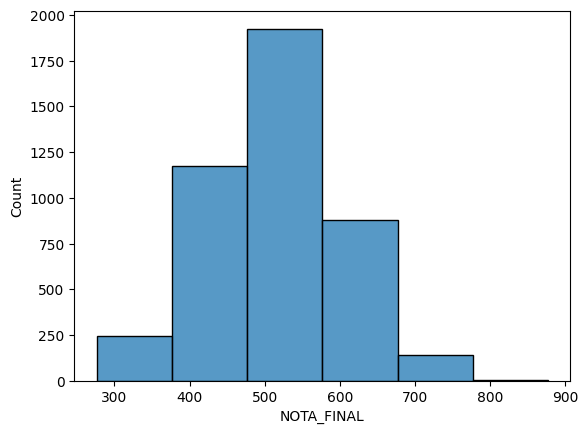

In [31]:
# Teste
import seaborn as sns
sns.histplot(x=y_test, binwidth=100)

<Axes: xlabel='NOTA_FINAL', ylabel='Count'>

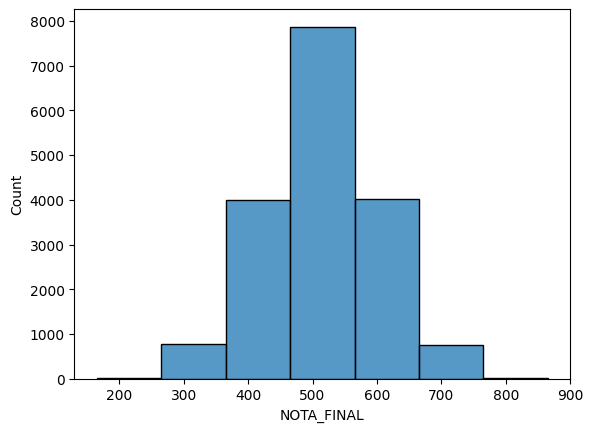

In [32]:
# Treino
import seaborn as sns
sns.histplot(x=y_train, binwidth=100)

## Testando modelo de RandomForest

### Desempenho do modelo nos dados de treino

In [34]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
regr.score(X_test, y_test)

0.2753399392442252

O RandomForest também teve um baixo desempenho, trazendo evidência de que as variáveis utilizadas sozinhas não são capazes de prever o desempenho do aluno no ENEM.

### Variáveis Relevantes

In [35]:
features = list(zip(regr.feature_importances_, X_train.columns))
features.sort(reverse=True)
for feature in features:
    print(f"{feature[1]}: {feature[0]}")

Q028: 0.13744020310013366
PANDEMIA_PRATICAS: 0.10109329350576622
TP_ESCOLA: 0.08947023103052835
Q006: 0.08923985144133002
PANDEMIA_GESTAO: 0.07572620834386616
GESTAO: 0.054531980274320845
PRATICAS: 0.047254353542995536
TP_FAIXA_ETARIA: 0.04489768726012339
Q034: 0.03959973791683535
Q003: 0.031609962131428394
Q004: 0.03039615447389542
Q001: 0.022637744075277733
TP_SEXO: 0.02130693038730786
Q025: 0.019419888841021166
Q033: 0.01904807421008141
Q030: 0.019015994163437643
Q032: 0.018688938082900265
Q026: 0.01827616790986527
REGIAO_NORDESTE: 0.015856088610007667
COR_RACA_1.0: 0.014946727103590391
REGIAO_SUDESTE: 0.014635290473302991
COR_RACA_3.0: 0.01304936891223526
REGIAO_NORTE: 0.010598354063675715
REGIAO_CENTROOESTE: 0.009885690015316827
COR_RACA_2.0: 0.009600333244253821
REGIAO_SUL: 0.009337015301752918
Q002: 0.008513270492842687
COR_RACA_4.0: 0.004018029869835556
NACIONALIDADE_1.0: 0.002787658654111525
NACIONALIDADE_2.0: 0.0027597060375578724
TP_ENSINO: 0.0022121244183712467
COR_RACA_5.0

In [38]:
# Mostrando apenas as mais relevantes (que estão acima da média)
media = 1 / len(X.columns)
for feature in features:
    if feature[0] > media:
        print(f"{feature[1]}: {feature[0]}")

Q028: 0.13744020310013366
PANDEMIA_PRATICAS: 0.10109329350576622
TP_ESCOLA: 0.08947023103052835
Q006: 0.08923985144133002
PANDEMIA_GESTAO: 0.07572620834386616
GESTAO: 0.054531980274320845
PRATICAS: 0.047254353542995536
TP_FAIXA_ETARIA: 0.04489768726012339
Q034: 0.03959973791683535
Q003: 0.031609962131428394
Q004: 0.03039615447389542


A Questão 28 dos Hábitos de Estudo trata sobre problemas enfrentados na pandemia (sem tempo de descanso, pouca atividade física, dificuldade de se concentrar, ...), e as Práticas na Pandemia trata sobre como o aluno estudou durante a pandemia e com que frequência.
<br><br>
O tipo de escola que o aluno estudou (se era pública ou não) e sua faixa salarial também parecem ter grandes impactos no desempenho do estudante no ENEM.
<br><br>
A maneira como o aluno fez a gestão dos seus estudos, tanto na pandemia quanto no geral, também são relevantes, bem como suas práticas de estudo no geral.
<br><br>
A idade do estudante parece ter grande impacto também. Isso é plausível, já que pessoas mais velhas tendem a ir melhor, por terem mais experiência com a prova de anos anteriores e por terem mais maturidade no geral.
<br><br>
A questão 34 fala sobre a avaliação do aluno sobre si próprio (o quanto ele se julga preparado para a prova). Embora essa autoavaliação parece ser relevante, não é tão relevante quantos outras variáveis.
<br><br>
Por fim, as Questões 3 e 4 dos Hábitos de Estudo também falam sobre o estudo do aluno na pandemia (mais especificamente, sobre o modelo de ensino e a evolução do aprendizado, respectivamente).
<br><br>
Das 11 variáveis com relevância acima da média, 5 falavam especificamente sobre a pandemia, 8 falavam sobre sobre o estudo do aluno e 2 falavam sobre a situação socioeconômica do estudante (sendo essas duas a terceira e a quarta variáveis mais relevantes).
